# Bias 
In this notebook, we study the analytical form of the bias on a set of experiments on the Rasch model and a set of experiments on sBCM.

In Rasch model
- delta_x refers to the item difficulties
- epsilon refers to the person ability

In sBCM
- delta_x refers to the opinion difference
- epsilon refers to the bounded confidence interval


In [1]:
from scipy.optimize import minimize, root_scalar
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
import sys
sys.path+=["../src"]
import bcm
import rasch_analysis as R

### $\rho$ vs bias
Rasch model with equally spaced item difficulties.
We vary epsilon, the number of questions (delta_x), and rho (the model stochasticity, i.e. the steepness of the sigmoid).

In [58]:
epsilon_values = [0.05, 0.1, 0.2, 0.4, 1.0, 1.6, 1.8, 1.9, 1.95]

In [ ]:
delta_xs = {"05": np.linspace(0,2,20),
            "005": np.linspace(0,2,200),
            "0005": np.linspace(0,2,2000),
            "00005": np.linspace(0,2,20000),
            "000005": np.linspace(0,2,200000),
            }


In [ ]:
# bias_rho = {u: {epsilon_real: [compute_bias(compute_p(epsilon_real, delta_xs[u], k), k) for k in np.arange(1,100)] for epsilon_real in [0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98]} for u in delta_xs}
bias_rho = {u: {epsilon_real: [R.compute_bias_(epsilon_real, delta_xs[u], k) for k in np.arange(1,100)] for epsilon_real in epsilon_values} for u in delta_xs}
df_bias = {u: pd.DataFrame(bias_rho[u]).stack().reset_index().rename(columns = {"level_0": "rho", "level_1": "epsilon", 0: "bias"}) for u in delta_xs}
vars = {u: {epsilon_real: [R.var_bias_(epsilon_real, delta_xs[u], k) for k in np.arange(1,100)] for epsilon_real in epsilon_values} for u in delta_xs}
df_vars = {u: pd.DataFrame(vars[u]).stack().reset_index().rename(columns = {"level_0": "rho", "level_1": "epsilon", 0: "var"}) for u in delta_xs}


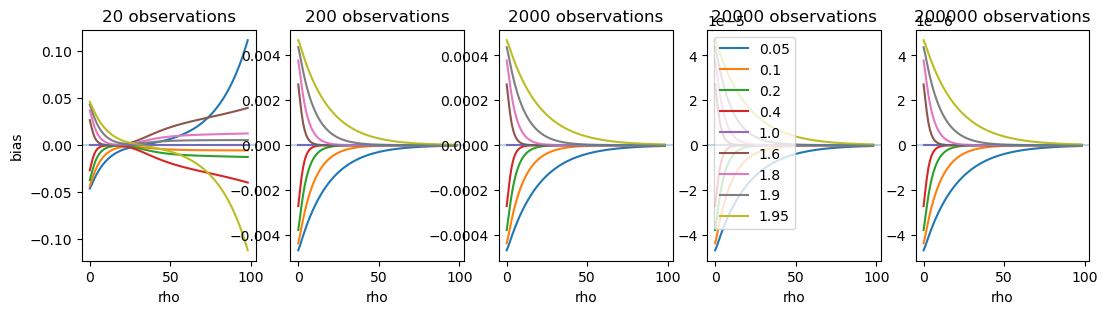

In [61]:
fig, axes = sbp(figsize = (13,3), ncols = 5, sharey = False)

for j, u in enumerate(df_bias):
    sns.lineplot(data = df_bias[u].assign(epsilon = lambda x: x["epsilon"].astype(str)), 
                 x = "rho", y = "bias", hue = "epsilon", ax = axes[j])
    axes[j].axhline(y = 0, alpha = 0.3)
    # axes[j].set_ylim(-0.1,0.1)
    axes[j].set_title(f"{len(delta_xs[u])} observations")
    axes[j].legend().set_visible(j == 3)
    axes[j].set_ylabel("" + (j == 0) *"bias")

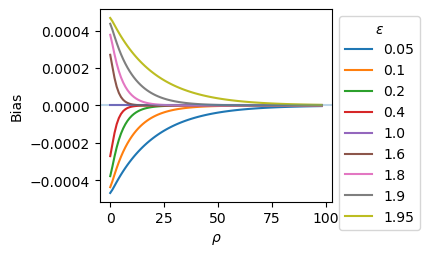

In [62]:
fig, axes = sbp(figsize = (3,2.5))

for u in ["0005"]:
    sns.lineplot(data = df_bias[u].assign(epsilon = lambda x: x["epsilon"].astype(str)), 
                 x = "rho", y = "bias", hue = "epsilon", ax = axes)
    axes.axhline(y = 0, alpha = 0.3)
    # axes[j].set_ylim(-0.1,0.1)
    # axes.set_title(f"{len(delta_xs[u])} observations")
    axes.set_xlabel(r"$\rho$")
    axes.legend(title = r"$\varepsilon$").set_bbox_to_anchor([1,1])
    axes.set_ylabel("Bias")

    fig.savefig(f"../paper/figs/rho_vs_bias.pdf", format = "pdf", bbox_inches = "tight")
    

### $N$ vs bias
We vary the number of agents, N.

In [43]:
rho = 15

In [ ]:
bias_rho = {u: {epsilon_real: [R.compute_bias_(epsilon_real, delta_xs[u], k) for k in np.arange(1,100)] 
                for epsilon_real in epsilon_values} 
                for u in delta_xs}

In [ ]:
bias_N = {u: {epsilon_real: R.compute_bias_(epsilon_real, np.linspace(0,1,int(N)), rho) 
                               for epsilon_real in [0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98]} 
                               for u,N in enumerate(np.logspace(1, 6, 201))}
df_N = pd.DataFrame(bias_N).T.assign(N = [int(u) for u in np.logspace(1, 6, 201)]).set_index("N").stack().reset_index().rename(columns = {"level_1": "epsilon", 0: "bias"})



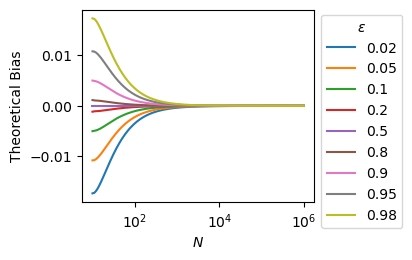

In [ ]:
fig, axes = sbp(figsize = (3,2.5), ncols = 1)


sns.lineplot(data = df_N.assign(epsilon = lambda x: x["epsilon"].astype(str)), 
             x = "N", y = "bias", hue = "epsilon")
axes.set_xscale("log")


axes.set_ylabel("Theoretical Bias")
axes.set_xlabel(r"$N$")

axes.legend(title = r"$\varepsilon$").set_bbox_to_anchor([1,1.01])

### Analysis experiments Rasch
Analysis of the experiments performed in rasch_analysis.py

In [ ]:
df_exp_ = pd.read_csv("/data/opdyn_identification/error_bias_rho_seed/exp_250411_minimize.csv", index_col = 0)
df_exp = df_exp_.groupby(["epsilon_real", "rho", "len_x"]).mean().reset_index()

len(df_exp_), len(df_exp_["seed"].unique())

(56093, 281)

In [11]:
x0 = 0.0000001

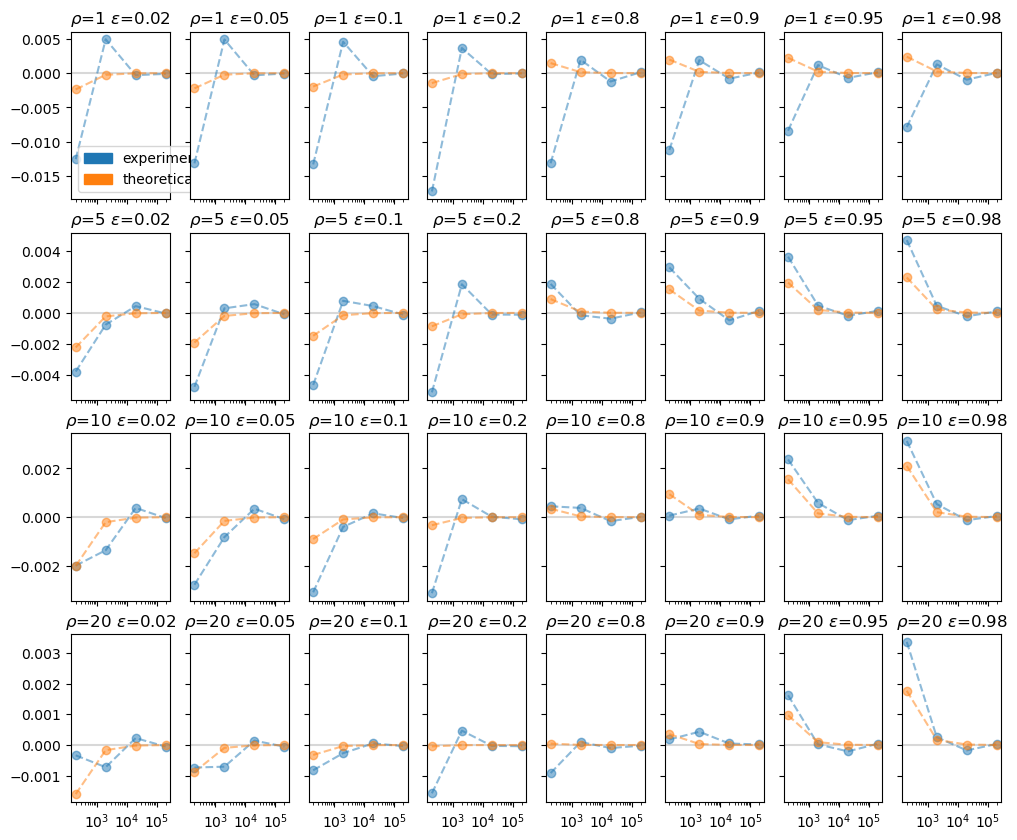

In [ ]:
df_ = df_exp_.copy()

fig, axes = sbp(ncols = 8, nrows = 4, figsize = (12,10), sharey = "row", sharex = True)

for j, epsilon_real in enumerate(df_exp_["epsilon_real"].unique()):
    for i, rho in enumerate(df_exp_["rho"].unique()[:-1]):        
        len_x = 20
        
        df_ = df_.query(f"len_x > {len_x}").query(f"(epsilon_real == {epsilon_real})&(rho == {rho})")
            
        axes[i,j].errorbar(x = df_.groupby("len_x").mean().reset_index()["len_x"],
                        y = df_.groupby("len_x").mean().reset_index()["empirical_error"], 
                        yerr = 0,
                        linestyle = "--",
                        marker = "o",
                        alpha = 0.5
                        )

        axes[i,j].errorbar(x = df_.groupby("len_x").mean().reset_index()["len_x"],
                        y = df_.groupby("len_x").mean().reset_index()["theoretical_bias"], 
                        yerr = 0, 
                        linestyle = "--",
                        marker = "o",
                        alpha = 0.5
                        )

        axes[i,j].axhline(0, color = "grey", alpha = 0.3)
        axes[i,j].set_xscale("log")

        axes[i,j].set_title(rf"$\rho$={rho} $\varepsilon$={epsilon_real}")
axes[0,0].legend(handles=[mpatches.Patch(color = sns.color_palette()[0], label = "experiment"), mpatches.Patch(color = sns.color_palette()[1], label = "theoretical")])

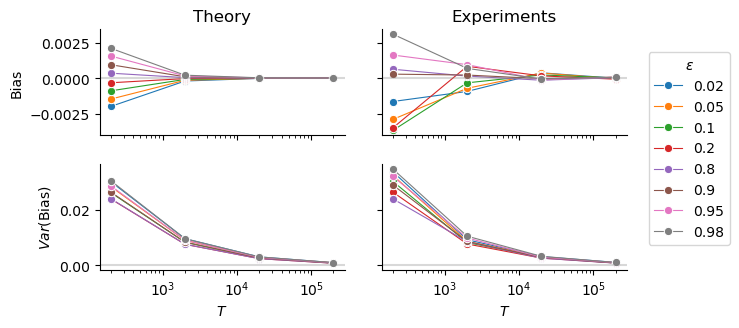

In [ ]:
rho = 10
len_x = 20
df_var = pd.DataFrame([(eps, s, np.sqrt(R.var_bias_(eps, np.arange(x0, 1, 1 / s), rho))) 
                       for s in sorted(df_exp_.query(f"len_x > {len_x}")["len_x"].unique())
                       for eps in df_exp_["epsilon_real"].unique()], columns = ["epsilon_real", "len_x", "var_bias"])

fig, axes = sbp(ncols = 2, nrows = 2, figsize = (6, 3), sharex = True, sharey = "row")
fig.tight_layout()

for j,var in enumerate(["theoretical_bias", "empirical_error"]):
        sns.lineplot(data = (df_exp_.query("len_x > @len_x").query("rho == @rho")
                        .assign(epsilon_real = lambda x: x["epsilon_real"].astype(str))
                        .groupby(["epsilon_real", "len_x"]).mean().reset_index()),
                x = "len_x",
                y = var,
                hue = "epsilon_real",
                # linestyle = "dashed",
                linewidth = 0.8,
                marker = "o",
                ax = axes[0,j]
                )
        axes[1,j].set_xlabel(r"$T$")
        axes[0,j].set_title(["Theory", "Experiments"][j])
        if j == 0:
                sns.lineplot(data = df_var.assign(epsilon_real = lambda x: x["epsilon_real"].astype(str)),
                        x = "len_x",
                        y = "var_bias",
                        hue = "epsilon_real",
                        # linestyle = "dashed",
                        linewidth = 0.8,
                        marker = "o",
                        ax = axes[1,j]
                        )
        else:
                sns.lineplot(data = (df_exp_.query("len_x > @len_x").query("rho == @rho")
                                .assign(epsilon_real = lambda x: x["epsilon_real"].astype(str))
                                .groupby(["epsilon_real", "len_x"]).std().reset_index()),
                        x = "len_x",
                        y = var,
                        hue = "epsilon_real",
                        # linestyle = "dashed",
                        linewidth = 0.8,
                        marker = "o",
                        ax = axes[1,j]
                        )
                
 
        for i in range(2):
                axes[i,j].set_xscale("log")
                axes[i,j].spines[['right', 'top']].set_visible(False)
                axes[i,j].axhline(0, color = "grey", alpha = 0.3)
                if i+j == 0:
                        axes[i,j].legend(title = r"$\varepsilon$").set_bbox_to_anchor([2.6,0.85])
                else:
                        axes[i,j].legend().set_visible(False)
                axes[i,0].set_ylabel([r"Bias", r"$Var($Bias$)$"][i])

# fig.savefig(f"../paper/figs/bias_theory_experiments.pdf", format = "pdf", bbox_inches = "tight")


In [29]:
rho, epsilon_real, len_x = 5, 0.9, 200
step = 1 / len_x
x = np.arange(x0, 1., step = step)
df_exp_.query(f"rho == {rho}").query(f"epsilon_real == {epsilon_real}").query(f"len_x == {len_x}").mean()[["empirical_error", "theoretical_bias"]]

empirical_error     0.002457
theoretical_bias    0.001518
dtype: float64

In [18]:
df_exp_.query(f"rho == {rho}").query(f"epsilon_real == {epsilon_real}").query(f"len_x == {len_x}").var()["empirical_error"], var_bias_(epsilon_real, x, rho)

(0.0016362945305136616, 0.001642933854020331)

### Saved experiments sBCM
Analysis of the experiments in experiments_sbcm.py

In [ ]:
df_exp_ = pd.concat([pd.read_csv("/data/opdyn_identification/error_bias_rho_seed/exp_250515_sbcm_000.csv", index_col = 0),
           pd.read_csv("/data/opdyn_identification/error_bias_rho_seed/exp_250523_sbcm_000.csv", index_col = 0)])

df_exp_ = df_exp_.assign(ratio_pos_interactions = lambda x: x["pos_interactions"] / x["T"])
df_exp = df_exp_.groupby(["epsilon_real", "rho", "T", "N"]).mean().reset_index()
len(df_exp_), len(df_exp_["seed"].unique())

(426526, 3950)

In [7]:
x0 = 0.0000001

In [8]:
rho = 15

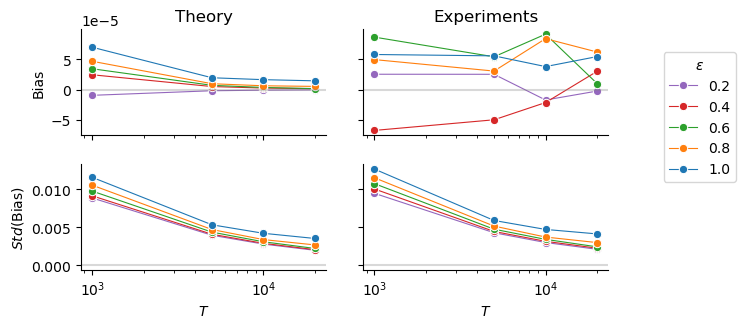

In [ ]:
df_plot = df_exp_.query("(epsilon_real < 1.1)&(epsilon_real > 0.1)")
palette = sns.color_palette("Set2")[:len(df_plot["epsilon_real"].unique())]
palette = sns.color_palette("tab10")[:len(df_plot["epsilon_real"].unique())]
palette.reverse()

fig, axes = sbp(ncols = 2, nrows = 2, figsize = (6, 3), sharex = True, sharey = "row")

fig.tight_layout()


for j,var in enumerate(["theoretical_bias", "empirical_error"]):
        sns.lineplot(data = (df_plot
                             .assign(epsilon_real = lambda x: x["epsilon_real"].astype(str))
                             .groupby(["epsilon_real", "T"]).mean().reset_index()),
                x = "T",
                y = var,
                hue = "epsilon_real",
                palette = palette,
                linewidth = 0.8,
                marker = "o",
                ax = axes[0,j]
                )
        axes[1,j].set_xlabel(r"$T$")
        axes[0,j].set_title(["Theory", "Experiments"][j])
        if j == 0:
                sns.lineplot(data = df_plot.assign(std_bias = lambda x: np.sqrt(x["var_bias"])).groupby(["epsilon_real", "T"])["std_bias"].mean().reset_index(),#df_var.assign(epsilon_real = lambda x: x["epsilon_real"].astype(str)),
                        x = "T",
                        y = "std_bias",
                        hue = "epsilon_real",
                        linewidth = 0.8,
                        palette = palette,
                        marker = "o",
                        ax = axes[1,j]
                        )
        else:
                sns.lineplot(data = (df_plot
                                     .assign(epsilon_real = lambda x: x["epsilon_real"].astype(str))
                                     .groupby(["epsilon_real", "T"]).std().reset_index()),
                        x = "T",
                        y = var,
                        hue = "epsilon_real",
                        palette = palette,
                        linewidth = 0.8,
                        marker = "o",
                        ax = axes[1,j]
                        )
                
 
        for i in range(2):
                axes[i,j].set_xscale("log")
                axes[i,j].spines[['right', 'top']].set_visible(False)
                axes[i,j].axhline(0, color = "grey", alpha = 0.3)
                if i+j == 0:
                        axes[i,j].legend(title = r"$\varepsilon$").set_bbox_to_anchor([2.7,0.85])
                else:
                        axes[i,j].legend().set_visible(False)
                axes[i,0].set_ylabel([r"Bias", r"$Std($Bias$)$"][i])
                

# fig.savefig(f"../paper/figs/bias_theory_experiments_sbcm.pdf", format = "pdf", bbox_inches = "tight")


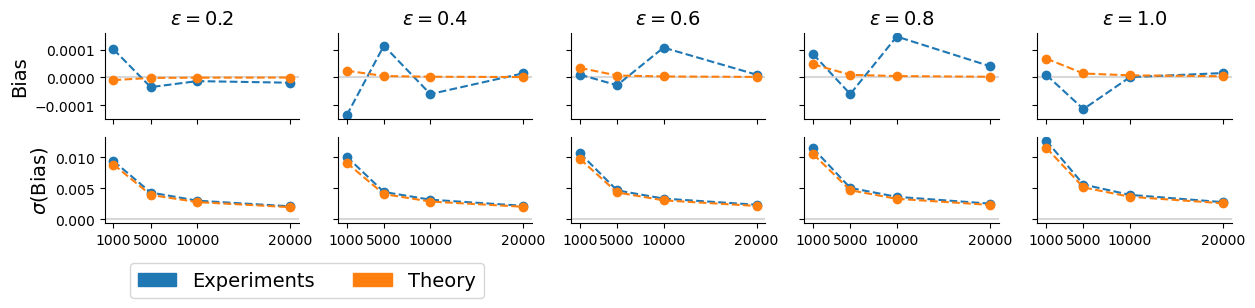

In [ ]:
df_plot = df_exp_.query("(epsilon_real < 1.1)&(epsilon_real > 0.1)&(N == 1000)")
fig, axes = sbp(ncols = len(df_plot["epsilon_real"].unique()), nrows = 2, figsize = (12,2.5), 
                sharey = "row", sharex = True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for j, epsilon_real in enumerate(df_plot["epsilon_real"].unique()):    
    df_ = df_plot.query(f"(epsilon_real == {epsilon_real})")
    axes[0,j].errorbar(x = df_.groupby("T").mean().reset_index()["T"],
                    y = df_.groupby("T").mean().reset_index()["empirical_error"], 
                    yerr = 0, 
                    linestyle = "--",
                    marker = "o",
                    )
    
 
    axes[0,j].errorbar(x = df_.groupby("T").mean().reset_index()["T"],
                    y = df_.groupby("T").mean().reset_index()["theoretical_bias"], 
                    yerr = 0,
                    linestyle = "--",
                    marker = "o",
                    )
    
    axes[1,j].errorbar(x = df_.groupby("T").mean().reset_index()["T"],
                    y = df_.groupby("T").std().reset_index()["empirical_error"], 
                    yerr = 0,
                    linestyle = "--",
                    marker = "o",
                    )

    axes[1,j].errorbar(x = df_.groupby("T").mean().reset_index()["T"],
                    y = np.sqrt(df_.groupby("T").mean().reset_index()["var_bias"]),
                    yerr = 0,
                    linestyle = "--",
                    marker = "o",
                    )
    axes[0,j].set_title(rf"$\varepsilon={epsilon_real}$", fontsize = 14)
    for i in range(2):
        axes[i,j].spines[['right', 'top']].set_visible(False)
        axes[i,j].axhline(0, color = "grey", alpha = 0.3)
        axes[i,0].set_ylabel([r"Bias", r"$\sigma($Bias$)$"][i], fontsize = 14)
    xticks = df_plot["T"].unique()
    axes[1,j].set_xticks(xticks)
    axes[1,j].set_xticklabels(xticks)

    
axes[1,0].legend(handles=[mpatches.Patch(color = sns.color_palette()[0], label = "Experiments"), 
                          mpatches.Patch(color = sns.color_palette()[1], label = "Theory")],
                          frameon = True, bbox_to_anchor = (2, -0.35), ncol = 2, fontsize = 14,
                          )


fig.show()
# fig.savefig(f"../paper/figs/bias_theory_experiments_sbcm.pdf", format = "pdf", bbox_inches = "tight")